# Soybean Conditions — Minimal Analysis

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

sys.path.append(os.path.abspath("."))
from src import get_soy_condition_features, SEVEN_STATES

%matplotlib inline


In [2]:
YEAR_FROM = 1987
YEAR_TO   = 2024
STATES    = SEVEN_STATES  # ("IA","IL","IN","OH","MO","MN","NE")
STATES_FILE = "data/processed/waob_features_states.csv"  # existing state-level WAOB-style file

FEATURES = [
    "gex_JA_min",
    "gex_JA_mean",
    "gex_week31",
    "gex_trend",
    "fair_JA_mean",
    "pvp_JA_max",
    "cond_index_JA_mean",
]
TARGET = "yield_bu_acre"


## 1) Load data

In [3]:
_, annual_cond = get_soy_condition_features(YEAR_FROM, YEAR_TO, STATES)

states = pd.read_csv(STATES_FILE)

cols_keep = ["state","year","yield_bu_acre","harvest_ha","acres_harvested",
             "trend","jun_shortfall","temp_JA","prec_JA","prec_JA_sq","dummy_2003"]
states = states[cols_keep].drop_duplicates(subset=["state","year"])

print("Annual conditions shape:", annual_cond.shape)
print("States WAOB shape:", states.shape)
states.tail(3)

Annual conditions shape: (273, 9)
States WAOB shape: (296, 11)


,state,year,yield_bu_acre,harvest_ha,acres_harvested,trend,jun_shortfall,temp_JA,prec_JA,prec_JA_sq,dummy_2003
293,US,2022,56.071932,1.233765e+08,4.734544e+07,35.0,0.451474,73.774935,3.838609,15.441285,0.0
294,US,2023,55.659603,1.174883e+08,4.522877e+07,36.0,1.023105,72.745083,3.851704,15.866829,0.0
295,US,2024,57.812707,1.210496e+08,4.666084e+07,37.0,0.000000,72.674866,3.848636,15.281408,0.0


## 2) Add US-weighted national rows

In [4]:
def add_us_weighted_row(df_conditions: pd.DataFrame) -> pd.DataFrame:
    if "harvest_ha" not in df_conditions.columns:
        raise ValueError("harvest_ha is required in df_conditions (merge states before calling).")
    num_cols = df_conditions.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c not in ["harvest_ha","year"]]

    def wmean(g: pd.DataFrame) -> pd.Series:
        w = g["harvest_ha"].fillna(0.0).astype(float)
        out = {c: (np.average(g[c].astype(float), weights=w) if w.sum() > 0 else np.nan)
               for c in num_cols}
        out["harvest_ha"] = float(w.sum())
        out["acres_harvested"] = float(g.get("acres_harvested", pd.Series([0]*len(g))).fillna(0).sum())
        return pd.Series(out)

    us = df_conditions.groupby("year", as_index=True).apply(wmean).reset_index()
    us["state"] = "US"
    return pd.concat([df_conditions, us], ignore_index=True, sort=False)


## 3) Merge

In [5]:
cond_y = annual_cond.merge(
    states[["state","year","yield_bu_acre","harvest_ha","acres_harvested"]],
    on=["state","year"], how="left"
)

df_full = add_us_weighted_row(cond_y)

df_us = (df_full[df_full["state"]=="US"]
         .dropna(subset=[TARGET])  # ensure yield exists
         .copy()
         .sort_values("year"))

print("df_full shape:", df_full.shape, "| df_us shape:", df_us.shape)
df_us[["year", TARGET] + [c for c in FEATURES if c in df_us.columns]].tail(5)


df_full shape: (312, 12) | df_us shape: (37, 12)


/var/folders/17/1l32x0xd6fdgz42c_pz2rhmm0000gn/T/ipykernel_69170/3243572381.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  us = df_conditions.groupby("year", as_index=True).apply(wmean).reset_index()


,year,yield_bu_acre,gex_JA_min,gex_JA_mean,gex_week31,gex_trend,fair_JA_mean,pvp_JA_max,cond_index_JA_mean
306,2020,56.310412,30.336663,35.240459,36.915929,-2.912161,22.368152,5.843162,2.468822
307,2021,57.587493,27.700702,30.771917,32.118240,-2.311659,28.197528,6.474712,2.435815
308,2022,56.071932,27.125365,30.234508,30.682373,-4.124315,28.525685,7.407190,2.422522
309,2023,55.659603,22.235757,27.149044,26.751636,1.551977,30.814944,10.431610,2.356335
310,2024,57.812707,32.231813,34.961023,35.542809,-0.962306,22.302825,5.429794,2.456012


## 4) Plots — Yield vs each feature

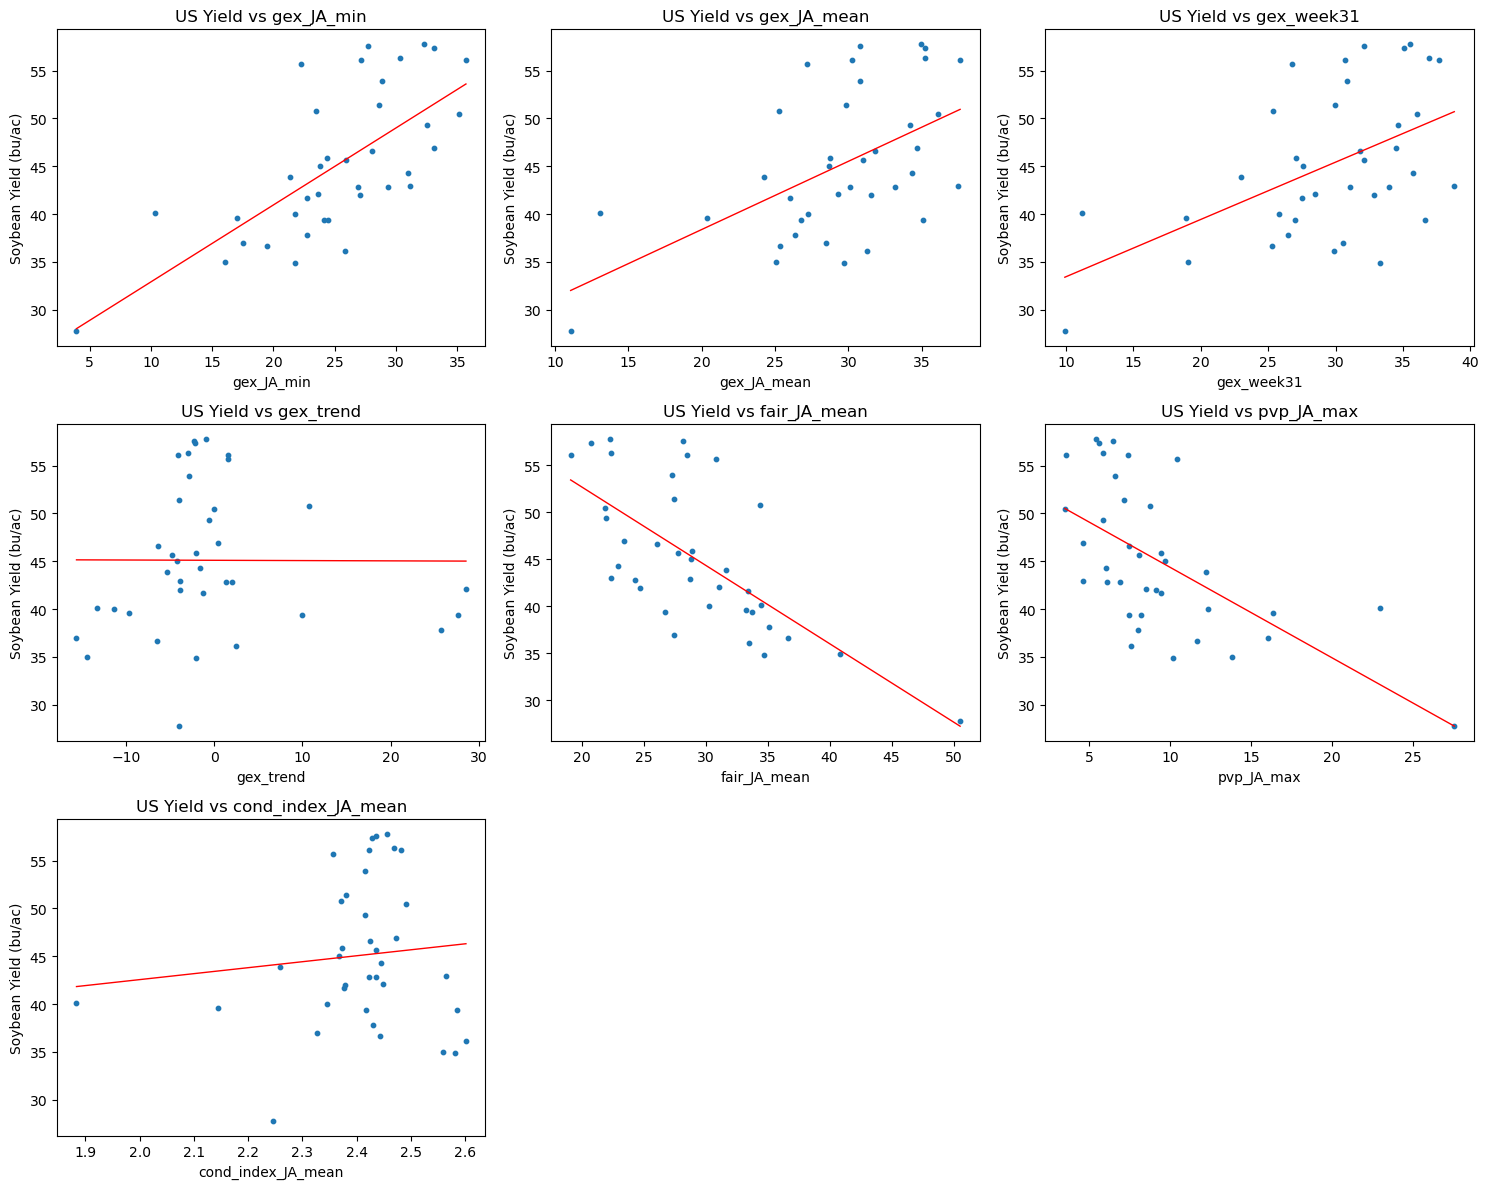

In [6]:
valid_features = [f for f in FEATURES if f in df_us.columns and df_us[f].notna().sum() >= 5]
n_feats = len(valid_features)

cols = 3  
rows = math.ceil(n_feats / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  

for i, feat in enumerate(valid_features):
    ax = axes[i]
    x = df_us[feat].astype(float).values
    y = df_us[TARGET].astype(float).values

    if np.isnan(x).any() or np.isnan(y).any() or len(x) < 5:
        ax.set_visible(False)
        continue

    A = np.vstack([x, np.ones_like(x)]).T
    beta, alpha = np.linalg.lstsq(A, y, rcond=None)[0]

    xs = np.linspace(x.min(), x.max(), 100)
    ys = beta * xs + alpha

    ax.scatter(x, y, s=10)
    ax.plot(xs, ys, color="red", lw=1)
    ax.set_title(f"US Yield vs {feat}")
    ax.set_xlabel(feat)
    ax.set_ylabel("Soybean Yield (bu/ac)")

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


## 5) Plots — Yield vs feature deviations from mean

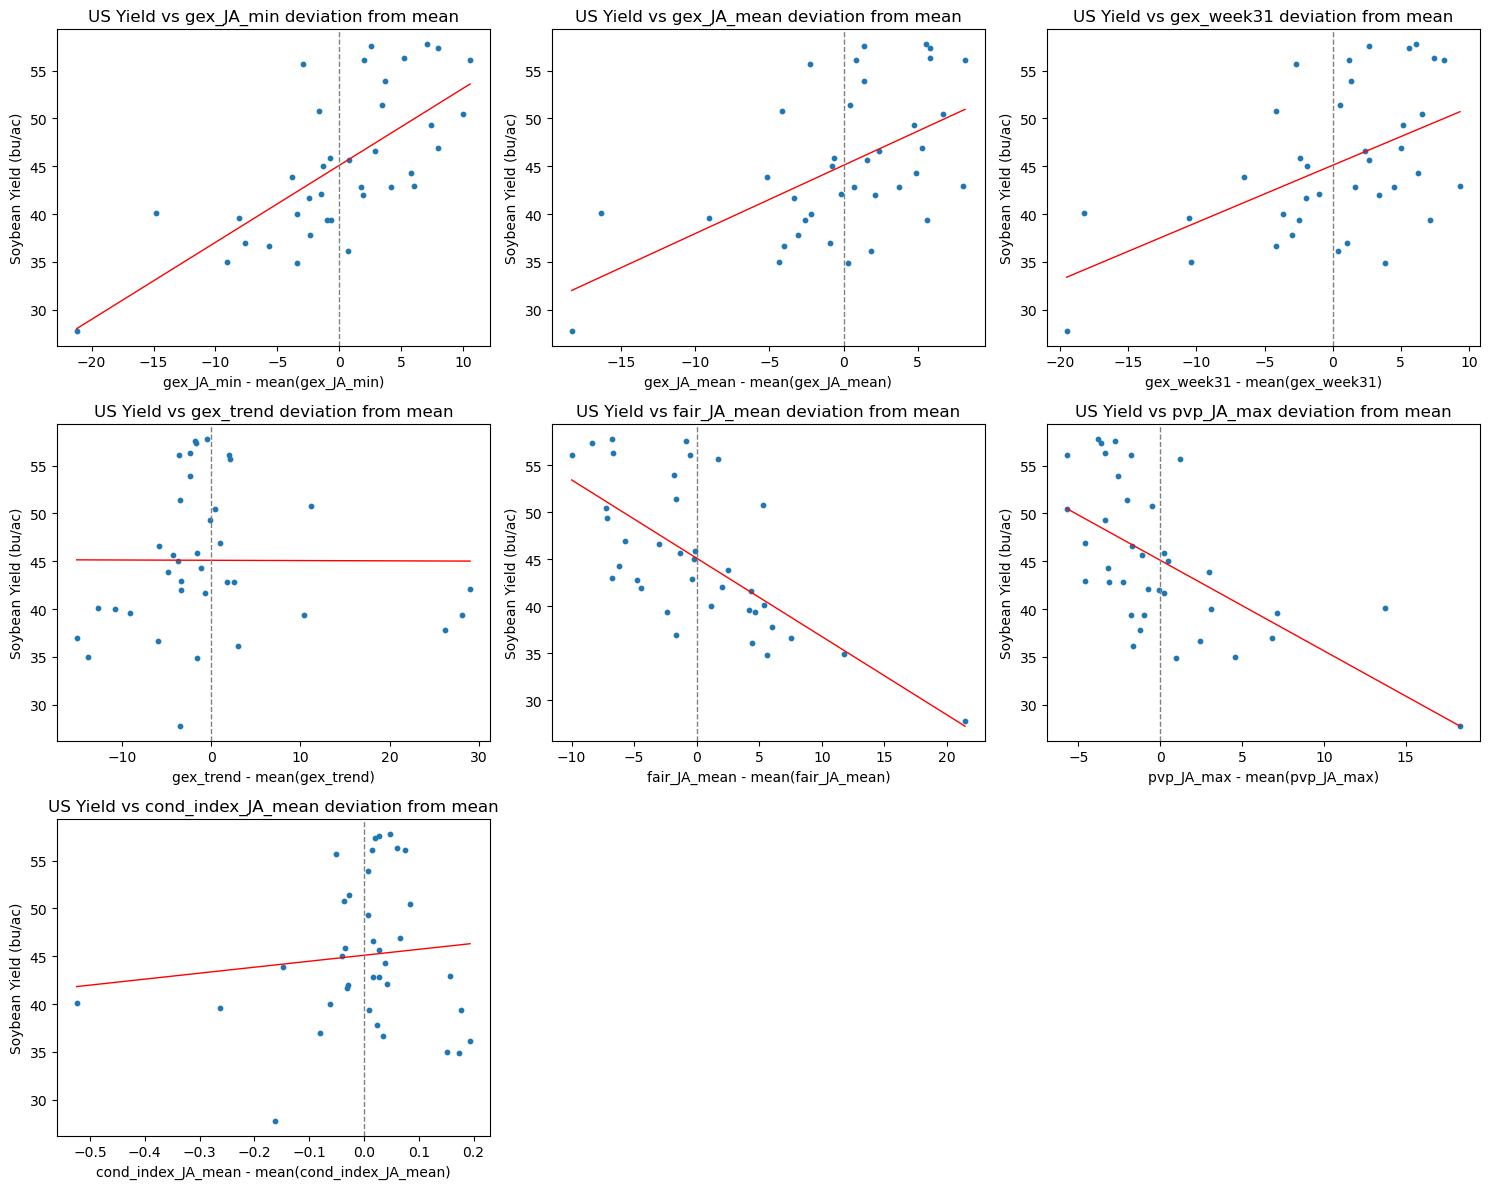

In [7]:
valid_features = [f for f in FEATURES if f in df_us.columns and df_us[f].notna().sum() >= 5]
n_feats = len(valid_features)

cols = 3  
rows = math.ceil(n_feats / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, feat in enumerate(valid_features):
    ax = axes[i]
    x = df_us[feat].astype(float).values
    y = df_us[TARGET].astype(float).values

    if np.isnan(x).any() or np.isnan(y).any() or len(x) < 5:
        ax.set_visible(False)
        continue

    x_dev = x - np.nanmean(x)

    A = np.vstack([x_dev, np.ones_like(x_dev)]).T
    beta, alpha = np.linalg.lstsq(A, y, rcond=None)[0]

    xs = np.linspace(x_dev.min(), x_dev.max(), 100)
    ys = beta * xs + alpha

    ax.scatter(x_dev, y, s=10)
    ax.plot(xs, ys, color="red", lw=1)
    ax.axvline(0, color="gray", linestyle="--", lw=1)

    ax.set_title(f"US Yield vs {feat} deviation from mean")
    ax.set_xlabel(f"{feat} - mean({feat})")
    ax.set_ylabel("Soybean Yield (bu/ac)")

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## 6) Rank features with univariate OLS

In [8]:
rows = []
for feat in FEATURES:
    if feat not in df_us.columns:
        continue
    x = df_us[feat].values.astype(float)
    y = df_us[TARGET].values.astype(float)
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]; y = y[mask]
    if len(x) < 5:
        continue

    A = np.vstack([x, np.ones_like(x)]).T
    beta, alpha = np.linalg.lstsq(A, y, rcond=None)[0]
    y_hat = beta*x + alpha
    ss_res = np.sum((y - y_hat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    rows.append({"feature": feat, "coef": float(beta), "intercept": float(alpha), "r2": float(r2)})

rank_df = pd.DataFrame(rows).sort_values("r2", ascending=False).reset_index(drop=True)
rank_df


,feature,coef,intercept,r2
0,gex_JA_min,0.805315,24.862421,0.483840
1,fair_JA_mean,-0.833037,69.340121,0.464691
2,pvp_JA_max,-0.945765,53.821579,0.374245
3,gex_JA_mean,0.712837,24.140763,0.293017
4,gex_week31,0.599047,27.465792,0.270059
5,cond_index_JA_mean,6.234728,30.095872,0.010812
6,gex_trend,-0.002964,45.106564,0.000015
